# **Life Expantancy**

<p>The data is collected from Kaggle-> <a> https://www.kaggle.com/kumarajarshi/life-expectancy-who </a></p>

<p>This dataset is comprised of data from all over the world from various countries aggregated by the World Health Organization (WHO for short). The data is an aggregate of many indicators for a particular country in a particular year. In essence, the data is multiple indicators in a time series separated by country. </p>

<h5><b>Questions that will be answered in this project:</b></h5>
<ol>
<li> What are the predicting variables actually affecting the life expectancy?</li>
<li> How does Infant and Adult mortality rates affect life expectancy?</li>
<li> What is the impact of schooling on the lifespan of humans?</li>
<li> Is there any difference between the life expectancy of Develped and Developing countries?</li>
<li> Build a model to predict the Life Expectancy.</li>
</p>


Importing libraries and reading data set

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Reading the file from github
url= 'https://raw.githubusercontent.com/Ziva1811/Data-Science-Projects/master/Project1/Life%20Expectancy%20Data.csv'
df=pd.read_csv(url)
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [0]:
df.shape

(2938, 22)

<h2><b>Data Preparation</b></h2> 


Before moving further, the string values for the columns/variables themselves are not very 'clean' so the following is a quick cleaning of the column/variable titles.






In [0]:
new_cols=[]
for col in df.columns:
  new_cols.append(col.strip().replace('  ',' ').replace(' ','_').lower())
df.columns=new_cols

df.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

<h3>Handling Missing Values</h3>

There are few things that must be done concerning missing values:

1.   Detection of missing values
2.   Dealing with missing values(drop/impute)






In [0]:
df.describe().iloc[:,1:]

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,69.248795,169.191269,28.607323,4.640667,281.501093,83.671293,220.691287,38.640545,85.514684,5.972192,85.469564,0.526991,5033.943592,7.508368e+06,4.703351,4.720470,0.640659,12.049874
std,9.462136,107.646049,25.699534,3.910036,384.161450,13.848933,329.192321,37.732345,15.270927,2.302224,15.217611,0.675962,5408.511820,8.646842e+06,3.925702,3.964268,0.171622,3.085673
min,45.600000,13.000000,1.000000,0.010000,0.000000,55.000000,0.000000,1.000000,52.000000,0.370000,52.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,4.900000
25%,63.200000,84.000000,4.000000,1.092500,4.685343,74.099237,0.000000,4.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,72.000000,157.000000,28.000000,4.140000,64.912906,87.000000,17.000000,34.000000,93.000000,5.910000,93.000000,0.100000,3116.561755,3.675929e+06,3.400000,3.400000,0.673000,12.300000
75%,75.600000,227.000000,43.766917,7.390000,441.534144,96.000000,360.250000,60.014815,97.000000,7.330000,97.000000,0.800000,7464.487887,1.181332e+07,7.100000,7.200000,0.772000,14.100000
max,89.000000,428.000000,95.000000,15.140000,1077.712092,99.000000,831.000000,138.000000,99.000000,11.660000,99.000000,1.800000,16784.346160,2.865628e+07,15.300000,15.500000,0.948000,19.500000


Some of things that may not make sense from above:



*  Adult mortality of 1? This is likely an error in measurement, but what values make sense here? May need to change to null if under a certain threshold.

* Infant deaths as low as 0 per 1000? That just isn't plausible - I'm deeming those values to actually be null. Also on the other end 1800 is likely an outlier, but it is possible in a country with very high birthrates and perhaps a not very high population total - this can be dealt with later.

*  BMI of 1 and 87.3? Pretty sure the whole population would not exist if that were the case. A BMI of 15 or lower is seriously underweight and a BMI of 40 or higher is morbidly obese, therefore a large number of these measurements just seem unrealistic...this variable might not be worth digging into at all.
*  Under Five Deaths, similar to infant deaths just isn't likely (perhaps even impossible) to have values at zero.

* GDP per capita as low as 1.68 (USD) possible? Doubtful - but perhaps the values may be outliers.



*  Population of 34 for an entire country?









<p> Understanding more through boxplots </p>

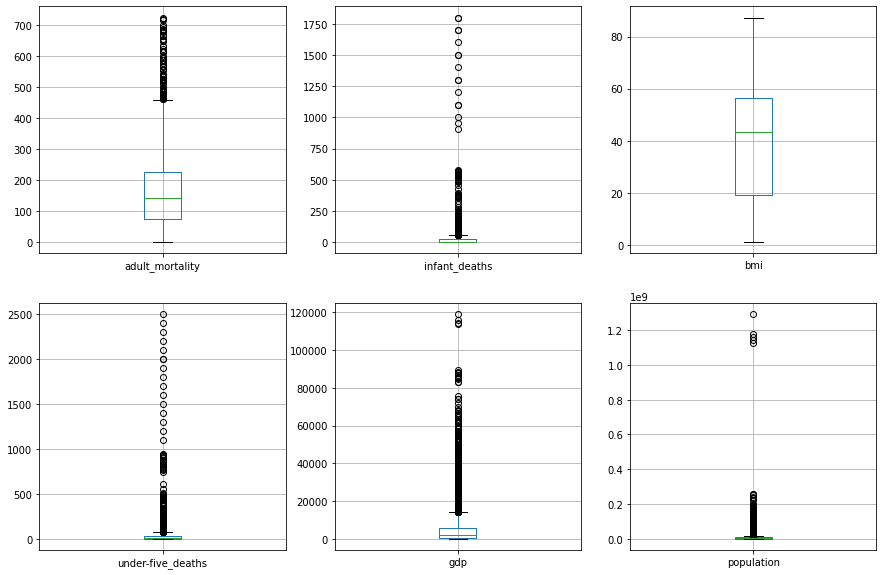

In [0]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['adult_mortality', 'infant_deaths', 'bmi', 'under-five_deaths', 'gdp', 'population'], start=1):
    plt.subplot(2, 3, i)
    df.boxplot(col)

There are a few of the above that could simply be outliers, but there are some that almost certainly have to be errors of some sort. Of the above variables, changes to null will be made for the following since these numbers don't make any sense:


*   Adult mortality rates lower than the 5th percentile

*   Infant deaths of 0 item

*   BMI less than 10 and greater than 50


*   Under Five deaths of 0ist item















In [0]:
mort_5_percentile = np.percentile(df.adult_mortality.dropna(), 5)   
df.adult_mortality= df.apply(lambda x: np.nan if x.adult_mortality < mort_5_percentile else x.adult_mortality, axis=1)

In [0]:
df['infant_deaths']= df['infant_deaths'].replace(0,np.nan)

In [0]:
df.bmi=df.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi >50) else x.bmi, axis=1)

In [0]:
df['under-five_deaths']= df['under-five_deaths'].replace(0,np.nan)

Checking % of null values in each column of the data

In [0]:
# % of null value in each column

round((df.isnull().mean())*100,2)

country                             0.00
year                                0.00
status                              0.00
life_expectancy                     0.34
adult_mortality                     5.28
infant_deaths                      28.86
alcohol                             6.60
percentage_expenditure              0.00
hepatitis_b                        18.82
measles                             0.00
bmi                                49.56
under-five_deaths                  26.72
polio                               0.65
total_expenditure                   7.69
diphtheria                          0.65
hiv/aids                            0.00
gdp                                15.25
population                         22.19
thinness_1-19_years                 1.16
thinness_5-9_years                  1.16
income_composition_of_resources     5.68
schooling                           5.55
dtype: float64

It appears that there are a decent amount of null values,hence just dropping the NULL values will result into loss of usefull data.


<h4>Dealing with missing values</h4>


Nearly half of the BMI variable's values are null, it is likely best to remove this variable altogether.

In [0]:
df.drop(['bmi'],axis=1,inplace=True)




In [0]:
df.shape

(2938, 21)

It looks like there are a lot of columns containing null values, since this is time series data assorted by country, the best course of action would be to interpolate the data by country, therefore imputation by year may be the best possible method here. 
Imputation of each year's mean is done below.



In [0]:
imputed_data = []
for year in list(df.year.unique()):
    year_data = df[df.year == year].copy()
    
    for col in list(year_data.columns)[3:]:
       year_data[col] = year_data[col].fillna(year_data[col].mean()).copy()
    imputed_data.append(year_data)
  
    
df = pd.concat(imputed_data).copy()

# df.isna().any()
imputed_data[0]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62.000000,0.010000,71.279624,65.0,1154,83.000000,6.0,8.16,65.0,0.1,584.259210,3.373649e+07,17.2,17.3,0.479,10.1
16,Albania,2015,Developing,77.8,74.0,35.129032,4.600000,364.975229,99.0,0,44.844961,99.0,6.00,99.0,0.1,3954.227830,2.887300e+04,1.2,1.3,0.762,14.2
32,Algeria,2015,Developing,75.6,19.0,21.000000,5.288333,0.000000,95.0,63,24.000000,95.0,7.08,95.0,0.1,4132.762920,3.987153e+07,6.0,5.8,0.743,14.4
48,Angola,2015,Developing,52.4,335.0,66.000000,5.288333,0.000000,64.0,118,98.000000,7.0,7.08,64.0,1.9,3695.793748,2.785935e+06,8.3,8.2,0.531,11.4
64,Antigua and Barbuda,2015,Developing,76.4,13.0,35.129032,5.288333,0.000000,99.0,0,44.844961,86.0,7.08,99.0,0.2,13566.954100,1.109741e+07,3.3,3.3,0.784,13.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,Venezuela (Bolivarian Republic of),2015,Developing,74.1,157.0,9.000000,5.288333,0.000000,87.0,0,10.000000,87.0,7.08,87.0,0.1,7185.331746,1.109741e+07,1.6,1.5,0.769,14.3
2874,Viet Nam,2015,Developing,76.0,127.0,28.000000,5.288333,0.000000,97.0,256,35.000000,97.0,7.08,97.0,0.1,7185.331746,1.109741e+07,14.2,14.5,0.678,12.6
2890,Yemen,2015,Developing,65.7,224.0,37.000000,5.288333,0.000000,69.0,468,47.000000,63.0,7.08,69.0,0.1,7185.331746,1.109741e+07,13.6,13.4,0.499,9.0
2906,Zambia,2015,Developing,61.8,33.0,27.000000,5.288333,0.000000,9.0,9,40.000000,9.0,7.08,9.0,4.1,1313.889646,1.615870e+05,6.3,6.1,0.576,12.5


It appears that this method took care of the null values.

In [0]:
df.shape

(2938, 21)

<h3> Handling Outliers </h2>

Similar to missing values, there are a few things that need done in order to deal with outliers:



1.  Detect the outliers

       *   Boxplots/histograms
       *   Tukey's Method


2.  Deal with outliers

       *   Drop outliers?
       *   Limit/Winsorize outliers?
       *   Transform the data using log/inverse/square root/etc?










<h4> Outliers Detection </h4>

First a boxplot will be created for each continuous variable in order to visually see if outliers exist.

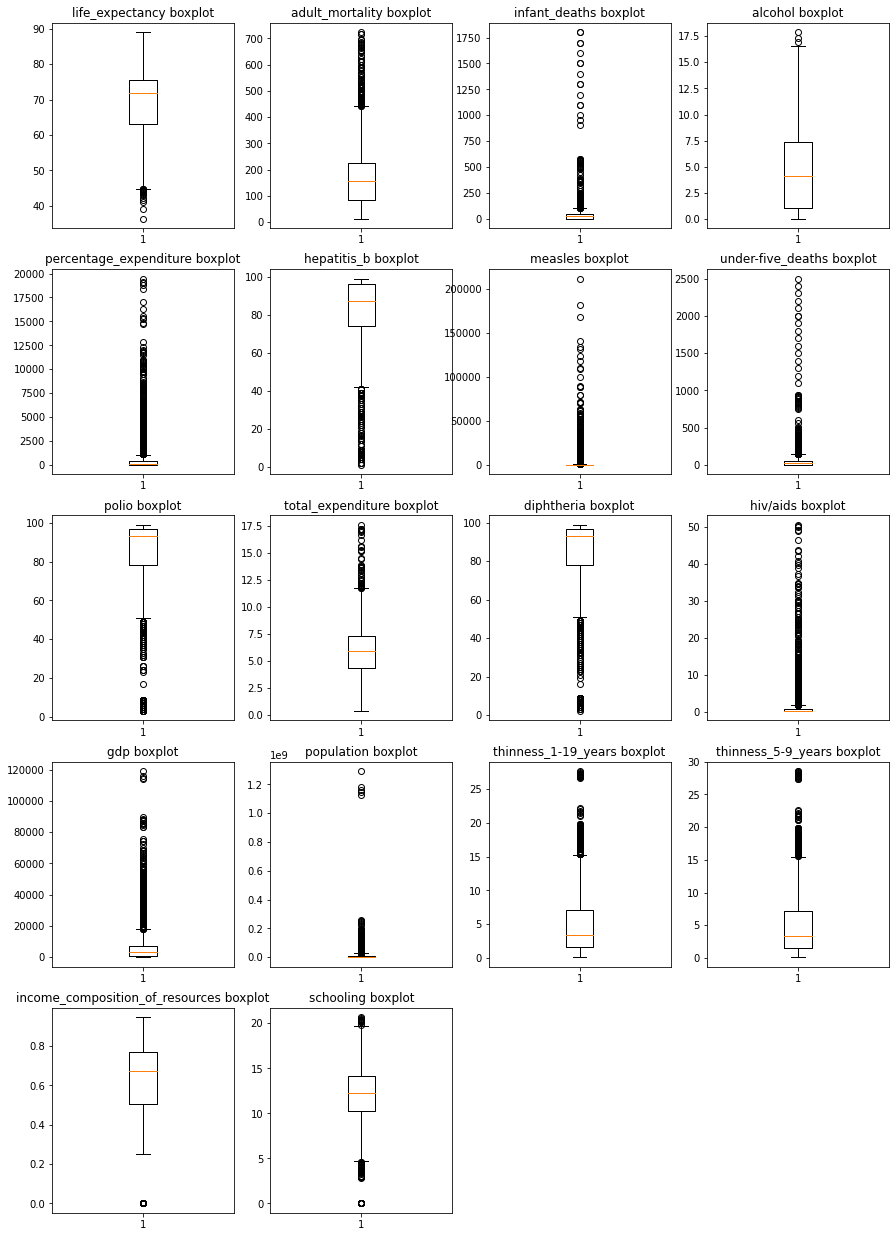

In [0]:
cont_vars = list(df.columns)[3:]
def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
    plt.show()

outliers_visual(df)

<p>Visually, it can be seen that there are a number of outliers for all of these variables - including the target variable, life expectancy. The same will be done statistically using Tukey's method below - outliers being considered anything outside of 1.5 times the IQR. </p>

In [0]:
# function to calculate no. of outliers in each column
def count_outlier(col,data):
  q25 = np.quantile(data[col],.25)
  q75 = np.quantile(data[col],.75)
  iqr= q75-q25
  max_limit= q75 + iqr*1.5
  min_limit=q25  - iqr*1.5
  outlier_count= len(np.where((data[col]< min_limit) | (data[col]> max_limit))[0])
  outlier_percent= (outlier_count/len(data[col]))
  print(8*'*' + col + 8*'*')
  print("No. of outliers: {} ".format(outlier_count))
  print("Percent of outliers: {} ".format(outlier_percent))
  print("\n")

In [0]:
for col in cont_vars:
  count_outlier(col,df)

********life_expectancy********
No. of outliers: 17 
Percent of outliers: 0.005786249149081007 


********adult_mortality********
No. of outliers: 97 
Percent of outliers: 0.03301565690946222 


********infant_deaths********
No. of outliers: 135 
Percent of outliers: 0.04594962559564329 


********alcohol********
No. of outliers: 3 
Percent of outliers: 0.0010211027910142954 


********percentage_expenditure********
No. of outliers: 389 
Percent of outliers: 0.13240299523485363 


********hepatitis_b********
No. of outliers: 222 
Percent of outliers: 0.07556160653505786 


********measles********
No. of outliers: 542 
Percent of outliers: 0.18447923757658272 


********under-five_deaths********
No. of outliers: 142 
Percent of outliers: 0.04833219877467665 


********polio********
No. of outliers: 279 
Percent of outliers: 0.09496255956432947 


********total_expenditure********
No. of outliers: 51 
Percent of outliers: 0.01735874744724302 


********diphtheria********
No. of outliers:

<p>It appears there are a decent amount of outliers in this dataset</p>

<h4> Dealing with outliers </h4>

There are a number of ways to deal with outliers in a dataset, the usual options are as follows:

1. Drop Outliers (best avoided in order to keep as much information as possible)

2. Limit values to upper and/or lower bounds (Winsorize the data)
 
3. Transform the data (log/inverse/square root/etc.)
     * advantage: can 'normalize' the data and eliminate outliers
     * disadvantage: cannot be done to variables containing values of 0 or below


<p> Since each variable has a unique amount of outliers and also has outliers on different sides of the data, the best route to take is probably winsorizing (limiting) the values for each variable on its own until no outliers remain. </p>
<p>The function below allows me to do exactly that by going variable by variable with the ability to use a lower limit and/or upper limit for winsorization.</p>
<p>Once a satisfactory limit is found (by visual analysis), the winsorized data will be saved in the wins_dict dictionary so the data can easily be accessed later.</p>

In [0]:
# function to winsorize each column according to given limits

from scipy.stats.mstats import winsorize
def test_wins(col, lower_limit=0, upper_limit=0):
  wins_data=winsorize(df[col],limits=[lower_limit,upper_limit])
  wins_dict[col]= wins_data


In [0]:
wins_dict = {}
test_wins(cont_vars[0], lower_limit=.01)
test_wins(cont_vars[1], upper_limit=.04)
test_wins(cont_vars[2], upper_limit=.05)
test_wins(cont_vars[3], upper_limit=.0025)
test_wins(cont_vars[4], upper_limit=.135)
test_wins(cont_vars[5], lower_limit=.1)
test_wins(cont_vars[6], upper_limit=.19)
test_wins(cont_vars[7], upper_limit=.05)
test_wins(cont_vars[8], lower_limit=.1)
test_wins(cont_vars[9], upper_limit=.02)
test_wins(cont_vars[10], lower_limit=.105)
test_wins(cont_vars[11], upper_limit=.185)
test_wins(cont_vars[12], upper_limit=.105)
test_wins(cont_vars[13], upper_limit=.07)
test_wins(cont_vars[14], upper_limit=.035)
test_wins(cont_vars[15], upper_limit=.035)
test_wins(cont_vars[16], lower_limit=.05)
test_wins(cont_vars[17], lower_limit=.025, upper_limit=.005)

<p>All the variables have now been winsorized as little as possible in order to keep as much data in tact as possible while still being able to eliminate the outliers.</p>
<p>Finally, small boxplots will be shown for each variable's winsorized data to show that the outliers have indeed been dealt with.</p>

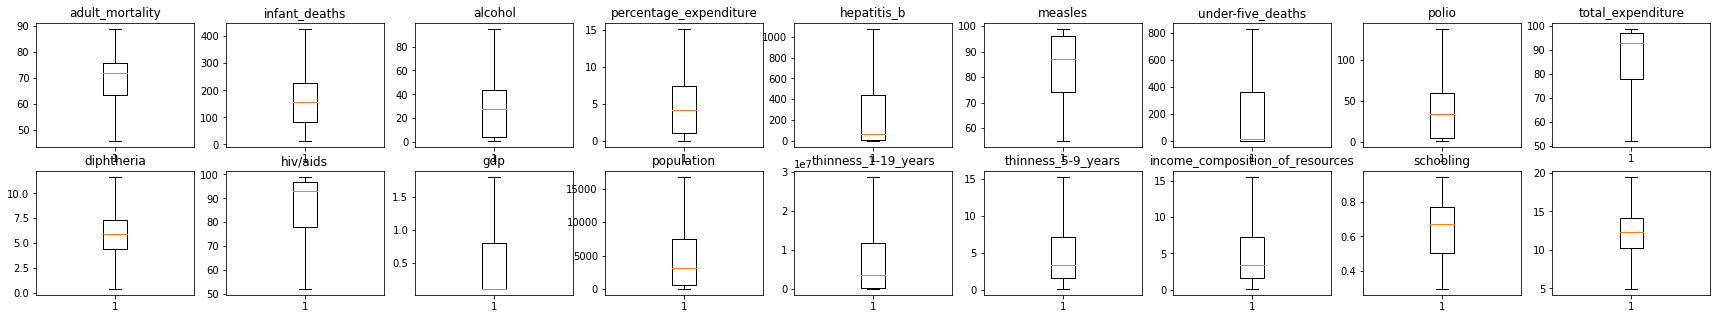

In [0]:
plt.figure(figsize=(30,5))
i=0
for col in cont_vars:
  i+=1
  plt.title(col)
  plt.subplot(2, 9, i)
  plt.boxplot(wins_dict[col])
 
plt.show()

<p> Keeping all the winsorized column back to the dataframe</p>

In [0]:
for col in cont_vars:
  df[col] = wins_dict[col]

In [0]:
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62.000000,0.010000,71.279624,65.0,831,83.000000,52.0,8.16,65.0,0.1,584.259210,2.865628e+07,15.3,15.5,0.479,10.1
16,Albania,2015,Developing,77.8,74.0,35.129032,4.600000,364.975229,99.0,0,44.844961,99.0,6.00,99.0,0.1,3954.227830,2.887300e+04,1.2,1.3,0.762,14.2
32,Algeria,2015,Developing,75.6,19.0,21.000000,5.288333,0.000000,95.0,63,24.000000,95.0,7.08,95.0,0.1,4132.762920,2.865628e+07,6.0,5.8,0.743,14.4
48,Angola,2015,Developing,52.4,335.0,66.000000,5.288333,0.000000,64.0,118,98.000000,52.0,7.08,64.0,1.8,3695.793748,2.785935e+06,8.3,8.2,0.531,11.4
64,Antigua and Barbuda,2015,Developing,76.4,13.0,35.129032,5.288333,0.000000,99.0,0,44.844961,86.0,7.08,99.0,0.2,13566.954100,1.109741e+07,3.3,3.3,0.784,13.9


<h3> Dealing with Categorical Value</h3>

<p> In this only one column i.e 'status' have categorical value.</p>
<p>Therefore pd.get_dummies() function used to create dummy variables

In [0]:
df=pd.concat([df.drop(['status'],axis=1),pd.get_dummies(df['status'])],axis=1)

In [0]:
df.shap

<p>Correlation between each variables can be used to check the how variables are related to each other</p>
<p> Some insights about correlation
<ul>
<li>The value of correlation is between -1,1 inclusive</l>
<li>Correlation is Positive when the values increase together, and</li>
<li>Correlation is Negative when one value decreases as the other increases.</li>
<li> Correlation is 0 when values are not dependent on each ther
<li>If correlation is >=0.7 or <=-0.7, then the values are said to be highly correlated to each other.</li>

In [0]:
df.corr()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Developed,Developing
year,1.000000,0.169796,-0.074960,-0.077173,-0.031642,0.032807,0.203759,-0.118772,-0.097158,0.118122,0.131170,0.150044,-0.088913,0.148771,0.067801,-0.049728,-0.050187,0.224731,0.210745,-0.001864,0.001864
life_expectancy,0.169796,1.000000,-0.677680,-0.222292,0.395089,0.488440,0.315120,-0.337887,-0.298626,0.573291,0.222306,0.578952,-0.796939,0.501011,0.011363,-0.514966,-0.512694,0.792878,0.742306,0.483121,-0.483121
adult_mortality,-0.074960,-0.677680,1.000000,0.119906,-0.187971,-0.293870,-0.214673,0.216200,0.168908,-0.348198,-0.121052,-0.351136,0.596271,-0.297774,-0.000562,0.332904,0.339266,-0.511340,-0.450785,-0.310207,0.310207
infant_deaths,-0.077173,-0.222292,0.119906,1.000000,-0.062119,-0.094053,-0.196145,0.323610,0.966996,-0.217511,-0.086289,-0.225997,0.124310,-0.059337,0.176352,0.196669,0.202573,-0.178389,-0.191062,-0.011644,0.011644
alcohol,-0.031642,0.395089,-0.187971,-0.062119,1.000000,0.378069,0.106352,-0.197193,-0.104954,0.265830,0.308434,0.272948,-0.193443,0.389598,-0.036283,-0.436755,-0.427166,0.475112,0.519757,0.580249,-0.580249
percentage_expenditure,0.032807,0.488440,-0.293870,-0.094053,0.378069,1.000000,0.122870,-0.194687,-0.131361,0.268385,0.159830,0.268411,-0.295791,0.712940,-0.070366,-0.331693,-0.333748,0.556006,0.530422,0.420621,-0.420621
hepatitis_b,0.203759,0.315120,-0.214673,-0.196145,0.106352,0.122870,1.000000,-0.266487,-0.239049,0.608008,0.071100,0.647198,-0.278977,0.172066,-0.004936,-0.134103,-0.139528,0.299493,0.290399,0.108121,-0.108121
measles,-0.118772,-0.337887,0.216200,0.323610,-0.197193,-0.194687,-0.266487,1.000000,0.368517,-0.320104,-0.161737,-0.315164,0.226305,-0.183792,0.222488,0.359571,0.364201,-0.274976,-0.329274,-0.130744,0.130744
under-five_deaths,-0.097158,-0.298626,0.168908,0.966996,-0.104954,-0.131361,-0.239049,0.368517,1.000000,-0.281667,-0.096826,-0.291057,0.198160,-0.102372,0.180288,0.235471,0.236927,-0.253539,-0.264996,-0.045339,0.045339
polio,0.118122,0.573291,-0.348198,-0.217511,0.265830,0.268385,0.608008,-0.320104,-0.281667,1.000000,0.164149,0.855849,-0.475611,0.309033,0.003618,-0.288660,-0.287206,0.515361,0.509788,0.265064,-0.265064


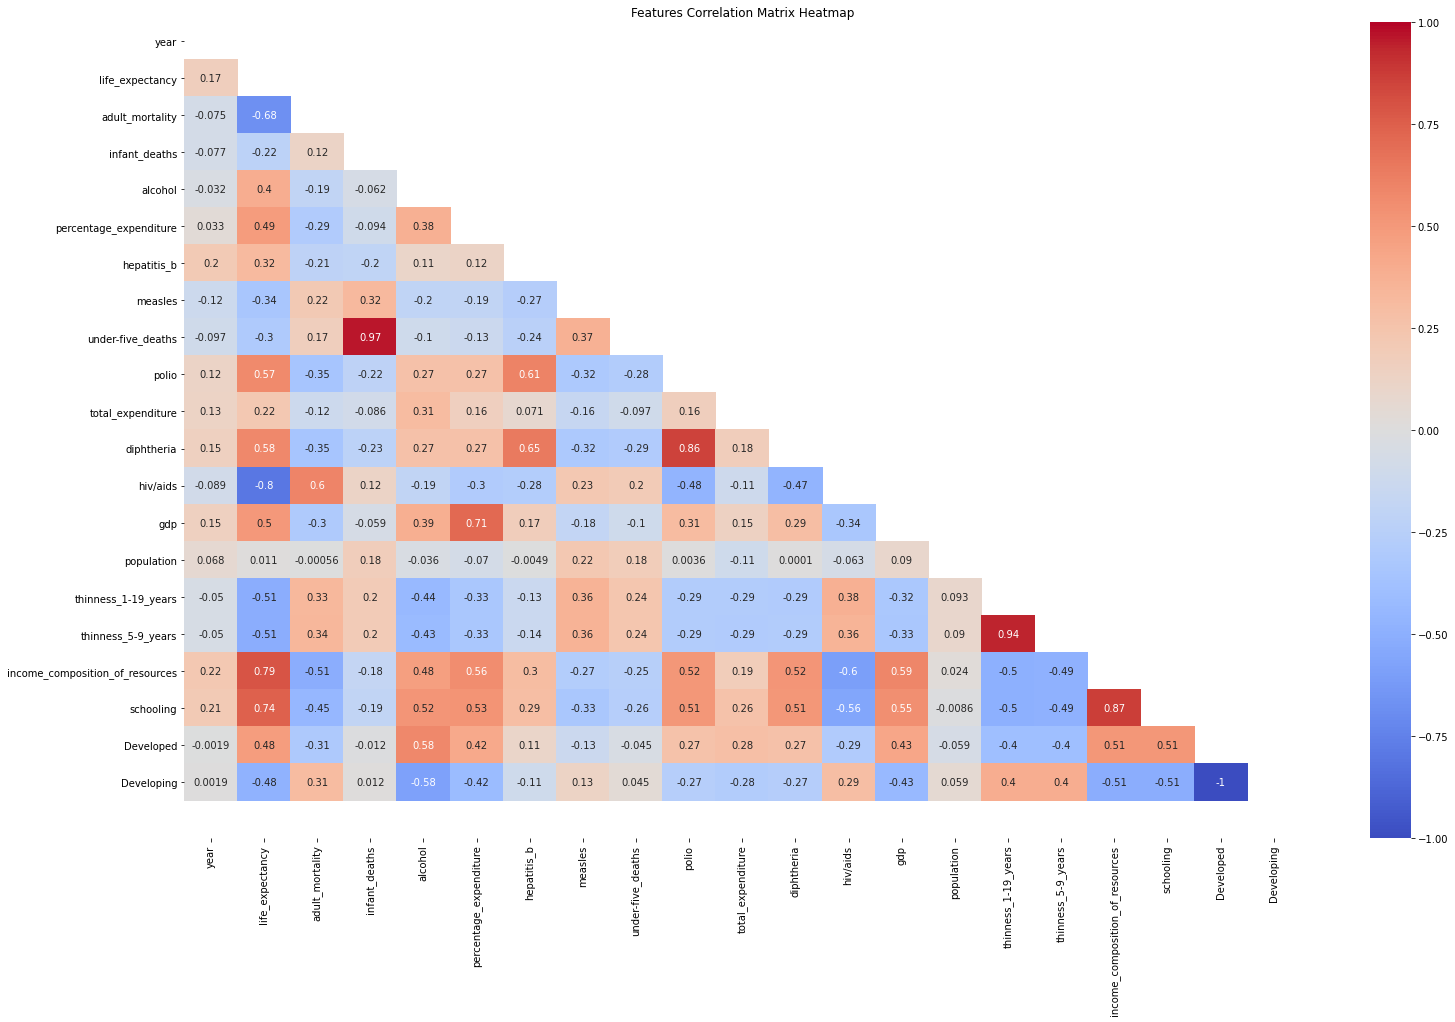

In [0]:
import seaborn as sns
def feat_heatmap():
    mask = np.triu(df.corr())
    plt.figure(figsize=(25,15))
    sns.heatmap(df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    plt.ylim(len(df.columns), 0)
    plt.title('Features Correlation Matrix Heatmap')
    plt.show()
feat_heatmap()

<p>The above heatmap is very useful! It very easily displays a number of important correlations between variables. Some general takeaways from the graphic above:

<h3><b>Q1 How does adulat and infant mortality rate affect the life Expectancy?</b></h3>
<p>Life Expectancy (target variable) appears to be negatively highly correlated  with Adult Mortality having correlation of approx -0.7, which means lower the adult mortality rate higher the life expectancy</p>
<p>Infant-deaths has correlation of -0.07 with life expectancy which seems to be negligible.</p>
<p> But, Infant Deaths-Under Five Deaths are highly correlated( correlation=0.92)AND Under Five Deaths is more highly correlated with life expectancy. Hence, Infant Deaths column is to be dropped from the dataframe </p>

<h3><b>Q2 How does schooling affect the life Expectancy?</b></h3>
<p>Life Expectancy (target variable) appears to be positively highly correlated with schooling, which means educated people will have more life expectancy.




In [0]:
df.drop(columns=['infant_deaths',], inplace=True)

<h4>Other insights of the correlation between different variables from the heat map</h4>
<ul>
<li>Life Expectancy (target variable) appears to be relatively highly correlated with HIV/AIDS (negative)</li>
<li>Life Expectancy (target variable) appears to be relatively highly correlated with Income Composition of Resources (positive)</li>
<li>Life expectancy (target variable) is extremely lowly correlated to population (nearly no correlation at all). Hence</li>
<li> The categorical columns, 'year' and 'country' will be dropped as they don't have significant differences among life expectancy.</li>
</ul></p>
<p>There are a number of variables that are very or extremely highly correlated with one another. In those cases, the variable which is most highly correlated to Life Expectancy (target variable) will be kept while the others will be dismissed.</p>
<p>The following are very/extremely highly correlated (correlation > .7 or correlation < -.7):
<ul>
<li>Infant Deaths-Under Five Deaths (drop Infant Deaths - Under Five Deaths is more highly correlated to Life Expectancy)</li>
<li>GDP-Percentage Expenditure (drop Percentage Expenditure - GDP is more higher correlated to Life Expectancy)
<li>Polio-Diphtheria (drop Polio - Diphtheria is more highly correlated to Life Expectancy)</li>
<li>Thinness 5-9-Thinness 1-19 (drop Thinness 10-19 as correlations to other variables are slightly higher)</li>
<li>Income Composition of Resources-Schooling (drop Schooling - Income Composition of Resources is more highly correlated with Life Expectancy)</li>



In [0]:
df.drop(columns=['percentage_expenditure','polio','thinness_1-19_years','schooling','population','country','year'], inplace=True)

<h3><b>Q3.  Is there any difference between the life expectancy of Develped and Developing countries?</b></h3>
<p>According to map above it can be seen that, correlation of 'Developing Countries' and 'Developed Coutries' have same value but are opposite in signs Hence we can say that Developed countries has more Life Expectancy than Developing Countries. </p>

In [0]:
#Dropping the columns that are not useful for building our model
df.drop(columns=['Developing'], inplace=True)

<h3><b>Q4. Predicting Variables that are actually effecting life expectancy are:</b>

In [0]:
print("The prdicting features for the life expectancy are:\n")
for col in df.columns:
  print(col)

The prdicting features for the life expectancy are:

life_expectancy
adult_mortality
alcohol
hepatitis_b
measles
under-five_deaths
total_expenditure
diphtheria
hiv/aids
gdp
thinness_5-9_years
income_composition_of_resources
Developed


<h2> Predicting the Life Expectancy</h2>
<p> Now we are done with rhe data cleaning part, and have all the variables that are related to life expectancy.</p><p> We are ready to build our Linear Regression model ro predict the life expectancy

In [0]:
X= df.drop('life_expectancy',axis=1)
y=df['life_expectancy']



<h3><b>Q5. Building the regression model to predict life expectancy</b></h3>

In [0]:
# splitting data into traing and test sets
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=.2, random_state=42)

#Instantiate
model=LinearRegression()

# fit the model
model.fit(X_train,y_train)

# predictt the model using x_test
pred_test= model.predict(X_test)

# Score the model
test_score= r2_score(y_test,pred_test)

# mean asquared error
mae= mean_squared_error(y_test,pred_test)

print("Rsquare: {} \n Mean squared error: {}".format(round(test_score,2), round(mae,2)))

Rsquare: 0.84 
 Mean squared error: 14.23
